In [35]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, make_scorer, accuracy_score
from sklearn.preprocessing import Imputer
np.random.seed(1)

In [2]:
features = pd.read_csv('../kaggle-quora/features/quora_features.csv')
wmd = pd.read_csv('../kaggle-quora/features/wmd_normwmd.csv')
magic = pd.read_csv('../kaggle-quora/features/train_magic.csv', header=0)

In [3]:
features = pd.concat([features, wmd], axis=1)
features = features.drop(['question1', 'question2'], axis=1)
features['q1_freq'] = magic['q1_freq'] 
features['q2_freq'] = magic['q2_freq']

In [4]:
features

,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_qratio,...,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec,wmd,norm_wmd,q1_freq,q2_freq
0,0,66,57,9,20,20,14,12,10,93,...,0.168999,0.186557,0.031817,-0.091902,0.050416,0.337301,0.564615,0.217555,1,2
1,0,51,88,-37,21,29,8,13,4,66,...,0.455910,0.592655,0.008735,0.094704,0.284010,-0.034444,3.772346,1.368796,8,3
2,0,73,59,14,25,24,14,10,4,43,...,0.307828,0.342306,0.239752,0.144554,0.026759,-0.474131,1.780585,0.639209,2,1
3,0,50,65,-15,19,26,11,9,0,9,...,0.506028,0.692421,-0.002527,0.069649,-0.244560,-0.265568,3.741994,1.263719,1,1
4,0,76,39,37,25,18,13,7,2,35,...,0.382770,0.480633,-0.133849,0.114777,0.217900,-0.338876,3.659165,1.240908,3,1
5,1,86,90,-4,26,27,16,16,8,72,...,0.337470,0.400061,0.102946,-0.077741,-0.335505,-0.057847,2.357449,0.780579,1,1
6,0,19,62,-43,14,20,4,11,0,20,...,0.597082,0.816676,-0.090366,-0.000266,0.296892,0.130717,3.546062,1.359521,1,1
7,1,30,41,-11,16,16,7,9,4,61,...,0.161125,0.187150,0.346824,0.368469,0.635773,0.865446,1.691323,0.736001,1,1
8,0,35,37,-2,19,16,8,8,6,87,...,0.000000,0.000000,0.202336,0.202336,-0.434927,-0.434927,0.000000,0.000000,2,3
9,0,60,49,11,25,24,9,9,3,49,...,0.337939,0.409126,0.120050,0.204449,-0.214573,-0.126814,1.258243,0.459266,1,1


# Replace inf with 1000.

In [14]:
print np.max(features[features['wmd'] != np.inf]['wmd']) # This is the max of 'wmx' column excluding inf values
features['wmd'] = features['wmd'].replace(np.inf, 1000)
features['norm_wmd'] = features['norm_wmd'].replace(np.inf, 1000)

6.94324350357


# Impute na with mean()

In [15]:
features.isnull().sum()

is_duplicate                        0
len_q1                              0
len_q2                              0
diff_len                            0
len_char_q1                         0
len_char_q2                         0
len_word_q1                         0
len_word_q2                         0
common_words                        0
fuzz_qratio                         0
fuzz_WRatio                         0
fuzz_partial_ratio                  0
fuzz_partial_token_set_ratio        0
fuzz_partial_token_sort_ratio       0
fuzz_token_set_ratio                0
fuzz_token_sort_ratio               0
cosine_distance                  1799
cityblock_distance                  0
jaccard_distance                  525
canberra_distance                   0
euclidean_distance                  0
minkowski_distance                  0
braycurtis_distance               525
skew_q1vec                          0
skew_q2vec                          0
kur_q1vec                           0
kur_q2vec   

In [16]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
features = imp.fit_transform(features)
features = pd.DataFrame(features)
features.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
dtype: int64

# Train/Test split

In [17]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.0,66.0,57.0,9.0,20.0,20.0,14.0,12.0,10.0,93.0,...,0.168999,0.186557,0.031817,-0.091902,0.050416,0.337301,0.564615,0.217555,1.0,2.0
1,0.0,51.0,88.0,-37.0,21.0,29.0,8.0,13.0,4.0,66.0,...,0.455910,0.592655,0.008735,0.094704,0.284010,-0.034444,3.772346,1.368796,8.0,3.0
2,0.0,73.0,59.0,14.0,25.0,24.0,14.0,10.0,4.0,43.0,...,0.307828,0.342306,0.239752,0.144554,0.026759,-0.474131,1.780585,0.639209,2.0,1.0
3,0.0,50.0,65.0,-15.0,19.0,26.0,11.0,9.0,0.0,9.0,...,0.506028,0.692421,-0.002527,0.069649,-0.244560,-0.265568,3.741994,1.263719,1.0,1.0
4,0.0,76.0,39.0,37.0,25.0,18.0,13.0,7.0,2.0,35.0,...,0.382770,0.480633,-0.133849,0.114777,0.217900,-0.338876,3.659165,1.240908,3.0,1.0


In [19]:
# Replace 'is_duplicate" with 0 if using logistic regression.

x_train, x_test, y_train, y_test = train_test_split(features.ix[:, features.columns != 0], \
                                                    features[0], \
                                                    test_size=0.15, \
                                                    random_state=42)

# Logistic Regression.

In [24]:
def link_function(x):
    return gamma_1*x/(gamma_1*x + gamma_0*(1 - x))

def log_loss_lf(y_true, y_pred):
    return log_loss(y_true, link_function(y_pred[:, 1]), eps=eps)

In [26]:
time_start = time.time()

log_reg = LogisticRegression()
params = {'C':[0.1, 0.5, 0.9], 'solver':['sag']}
log_reg_cv = GridSearchCV(log_reg, \
                          param_grid=params, \
                          scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True), \
                          verbose=10)
log_reg_cv.fit(x_train, y_train)

time_end = time.time()
print 'Total time: ', time_end - time_start

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=0.1, solver=sag ...............................................
[CV] ............... C=0.1, solver=sag, score=-0.495403, total=  14.6s
[CV] C=0.1, solver=sag ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s


[CV] ............... C=0.1, solver=sag, score=-0.495012, total=  14.3s
[CV] C=0.1, solver=sag ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.1s remaining:    0.0s


[CV] ............... C=0.1, solver=sag, score=-0.491564, total=  14.7s
[CV] C=0.5, solver=sag ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   43.9s remaining:    0.0s


[CV] ............... C=0.5, solver=sag, score=-0.495404, total=  14.9s
[CV] C=0.5, solver=sag ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   58.9s remaining:    0.0s


[CV] ............... C=0.5, solver=sag, score=-0.495012, total=  16.2s
[CV] C=0.5, solver=sag ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


[CV] ............... C=0.5, solver=sag, score=-0.491565, total=  15.4s
[CV] C=0.9, solver=sag ...............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.5min remaining:    0.0s


[CV] ............... C=0.9, solver=sag, score=-0.495404, total=  14.7s
[CV] C=0.9, solver=sag ...............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.8min remaining:    0.0s


[CV] ............... C=0.9, solver=sag, score=-0.495012, total=  14.8s
[CV] C=0.9, solver=sag ...............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.0min remaining:    0.0s


[CV] ............... C=0.9, solver=sag, score=-0.491564, total=  14.9s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.3min finished


Total time:  159.53984189


In [34]:
print 'Params: ', log_reg_cv.cv_results_['params']
print 'Mean Train Score: ', log_reg_cv.cv_results_['mean_train_score']
print 'Mean Test Score: ', log_reg_cv.cv_results_['mean_test_score']
print 'Best Param: ', log_reg_cv.best_params_
print 'Best Score: ', log_reg_cv.best_score_

Params:  ({'C': 0.1, 'solver': 'sag'}, {'C': 0.5, 'solver': 'sag'}, {'C': 0.9, 'solver': 'sag'})
Mean Train Score:  [-0.49389701 -0.49389728 -0.49389731]
Mean Test Score:  [-0.49399306 -0.49399342 -0.49399327]
Best Param:  {'C': 0.1, 'solver': 'sag'}
Best Score:  -0.493993064462


In [44]:
y_pred_proba = log_reg_cv.predict_proba(x_test)
y_pred = log_reg_cv.predict(x_test)
print log_loss(y_test, y_pred_proba)
print accuracy_score(y_test, y_pred)

0.496400757551
0.725710705099


# Try xgboost

In [69]:
import xgboost as xgb

xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['eval_metric'] = 'logloss'
xgb_params['eta'] = 0.22
xgb_params['max_depth'] = 5

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_test, label=y_test)

# XGBoost cv to check training condition
# Skip this part if you don't care about CV result

In [12]:
time_start = time.time()

model_cv = xgb.cv(xgb_params, \
                  d_train, \
                  1000, \
                  nfold=3, \
                  metrics='logloss', \
                  early_stopping_rounds=50, \
                  verbose_eval=10)

time_end = time.time()
print 'Total time: ', time_end - time_start

[0]	train-logloss:0.649054+3.6527e-05	test-logloss:0.649194+0.000149337
[10]	train-logloss:0.453921+0.00145649	test-logloss:0.454845+0.000316548
[20]	train-logloss:0.400296+0.00173305	test-logloss:0.40187+0.000781861
[30]	train-logloss:0.379279+0.00137322	test-logloss:0.381524+0.00149406
[40]	train-logloss:0.368671+0.00112555	test-logloss:0.371486+0.00187811
[50]	train-logloss:0.362296+0.00126254	test-logloss:0.365651+0.00176216
[60]	train-logloss:0.35762+0.00113469	test-logloss:0.361564+0.00194234
[70]	train-logloss:0.354129+0.00105996	test-logloss:0.358599+0.0020286
[80]	train-logloss:0.351512+0.00124736	test-logloss:0.356525+0.0018942
[90]	train-logloss:0.349149+0.00128629	test-logloss:0.354742+0.00189338
[100]	train-logloss:0.346842+0.00152367	test-logloss:0.352986+0.00173107
[110]	train-logloss:0.345045+0.00162053	test-logloss:0.351786+0.00166015
[120]	train-logloss:0.343182+0.0016674	test-logloss:0.350544+0.00164737
[130]	train-logloss:0.34139+0.00172956	test-logloss:0.349353+0.0

In [67]:
STAMP = str()
for item in xgb_params.values():
    STAMP = STAMP + '_' + str(item)
STAMP

'_binary:logistic_0.11_5_logloss'

In [68]:
model_cv.to_csv('./xgb_history_{}.csv'.format(STAMP))
print 'Total rounds used: ', len(model_cv)

Total rounds used:  1000


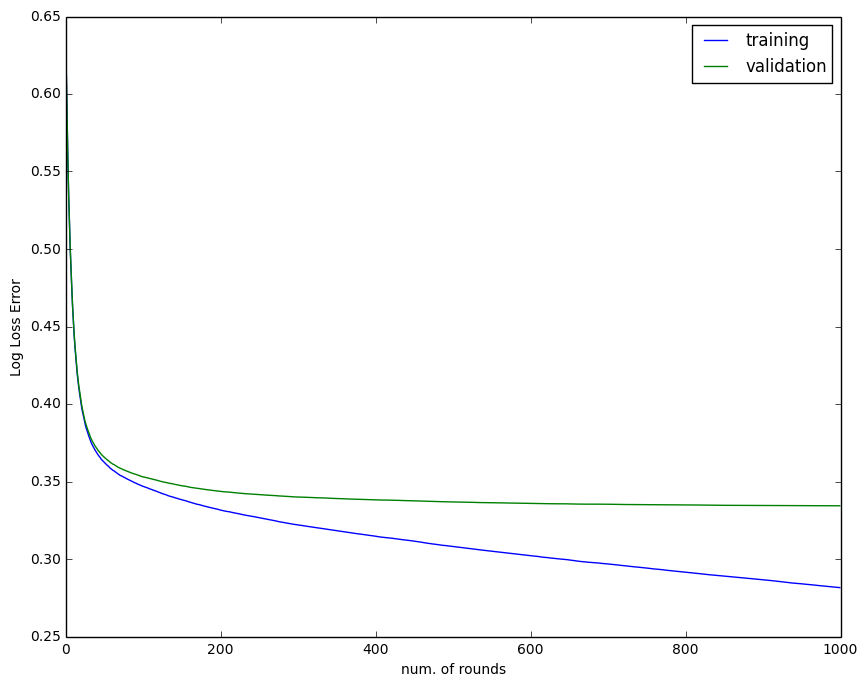

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(model_cv['train-logloss-mean'], label='training')
plt.plot(model_cv['test-logloss-mean'], label='validation')
# plt.xlim(200, 400)
# plt.ylim(0.3, 0.38)
plt.xlabel('num. of rounds')
plt.ylabel('Log Loss Error')
plt.legend()
plt.show()

# XGB training and prediction

In [70]:
xgb_params

{'eta': 0.22,
 'eval_metric': 'logloss',
 'max_depth': 5,
 'objective': 'binary:logistic'}

In [71]:
time_start = time.time()

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(xgb_params, \
                d_train, \
                1000, \
                watchlist, \
                early_stopping_rounds=50, \
                verbose_eval=10)

time_end = time.time()
print 'Total time: ', time_end - time_start

[0]	train-logloss:0.610272	valid-logloss:0.610796
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.396308	valid-logloss:0.398735
[20]	train-logloss:0.36935	valid-logloss:0.372633
[30]	train-logloss:0.359433	valid-logloss:0.363522
[40]	train-logloss:0.353197	valid-logloss:0.357949
[50]	train-logloss:0.34787	valid-logloss:0.353532
[60]	train-logloss:0.343787	valid-logloss:0.350318
[70]	train-logloss:0.340892	valid-logloss:0.348289
[80]	train-logloss:0.338032	valid-logloss:0.346371
[90]	train-logloss:0.335379	valid-logloss:0.344586
[100]	train-logloss:0.333447	valid-logloss:0.343542
[110]	train-logloss:0.331193	valid-logloss:0.342131
[120]	train-logloss:0.329591	valid-logloss:0.341427
[130]	train-logloss:0.327946	valid-logloss:0.340482
[140]	train-logloss:0.326485	valid-logloss:0.339907
[150]	train-logloss:0.324977	valid-logloss:0.339486
[160]	train-logloss:0.32372	va

In [72]:
xgb_pred = bst.predict(xgb.DMatrix(x_test))
print xgb_pred
print log_loss(y_test, xgb_pred)

[  8.47603753e-02   8.39267254e-01   2.90273329e-05 ...,   5.66116250e-05
   1.23693615e-01   1.38218120e-01]
0.331926484013


In [73]:
xgb_pred_binary = xgb_pred.copy()
xgb_pred_binary[xgb_pred >= 0.5] = 1
xgb_pred_binary[xgb_pred < 0.5] = 0
print accuracy_score(y_test, xgb_pred_binary)

0.839604907328
